In [72]:
import pandas
import torch
import json
from tqdm import tqdm

data = []
with open('./mmmu_cls/mmmu_cls.jsonl') as f:
    for line in f:
        data.append(json.loads(line))
print(len(data))
print(data[0])

168
{'image_path': 'mmmu_cls/image/dev_Accounting_1_1.png', 'image_url': 'https://mitalinlp.oss-cn-hangzhou.aliyuncs.com/rallm/search_decision_KnowB/held_out_data/mmmu_image/dev_Accounting_1_1.png', 'question': 'Each of the following situations relates to a different company. <image 1> For company B, find the missing amounts.', 'answer': '$77,490', 'question_id': 'dev_Accounting_1', 'label': 'Accounting', 'label_id': 0}


In [73]:
from PIL import Image, ImageOps

def resize_with_padding(img, new_path, target_size=(512, 512), padding_mode="constant"):
    """
    保持比例调整大小，并用 padding 填充至目标尺寸
    Args:
        img: PIL Image
        target_size: (width, height)
        padding_mode: "constant"（黑边）/"edge"（边缘填充）/"reflect"（镜像填充）
    Returns:
        Resized and padded PIL Image
    """
    img = Image.open(img)
    img = img.convert("RGB")
    width, height = img.size
    target_w, target_h = target_size
    
    # 计算缩放比例
    scale = min(target_w / width, target_h / height)
    new_width = int(width * scale)
    new_height = int(height * scale)
    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # 计算 padding 位置
    delta_w = target_w - new_width
    delta_h = target_h - new_height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    
    # 应用 padding
    if padding_mode == "constant":
        padded_img = ImageOps.expand(img, padding, fill=(0, 0, 0))  # 黑边
    elif padding_mode == "edge":
        padded_img = ImageOps.expand(img, padding, fill="edge")  # 边缘填充
    elif padding_mode == "reflect":
        padded_img = ImageOps.expand(img, padding, fill="reflect")  # 镜像填充
    else:
        raise ValueError("padding_mode 必须是 'constant'/'edge'/'reflect'")

    padded_img.save(new_path)

In [80]:
import torch
from torchvision.transforms.functional import to_pil_image
import os

def save_image(tensor, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    img = to_pil_image(tensor.to(torch.uint8))
    img.save(path)

In [74]:
# Make cls train dataset
import cv2
reload = True

if reload:
    with open('mmmu_cls/mmmu_cls_resized.jsonl', 'w') as g:
        train = []
        for d in tqdm(data, ncols=100):
            image_path = d['image_path']
            new_resized_path = image_path.replace('/image/', '/resized_image/')
            resize_with_padding(image_path, new_resized_path, target_size=(512,512), padding_mode='constant')

            d['image_path'] = new_resized_path
            g.write(json.dumps(d)+'\n')

            d['image'] = cv2.imread(new_resized_path).tolist()

            train.append(d)
else:
    with open('mmmu_cls/mmmu_cls_resized.jsonl') as f:
        lines = list(f.readlines())
        train = [json.loads(i) for i in tqdm(lines)]
        for i in tqdm(train):
            i['image'] = cv2.imread(i['image_path']).tolist()
            

print(len(train))

100%|█████████████████████████████████████████████████████████████| 168/168 [00:35<00:00,  4.76it/s]

168


In [82]:
save_image(
    torch.tensor(train[0]['image']).permute(2,0,1).float(),
    'mmmu_cls/linf_att_image/test.jpg'
)

In [89]:
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader 
import torch
from torch import optim

torch.manual_seed(42)


class MMMUDataset(Dataset):
    def __init__(self, data_list):
        super().__init__()
        self.data = data_list
        self.len = len(data_list)

    def __getitem__(self, index):
        return {
            'label': self.data[index]['label_id'],
            'feature': torch.tensor(self.data[index]['image']).permute(2, 0, 1).float(),
            'image_path': self.data[index]['image_path']
        }
    
    def __len__(self):
        return self.len
    

def get_mnist_loaders(batch_size, shuffle):
    train_dataset = MMMUDataset(train)
    # test_dataset = MMMUDataset(test)

    train_dataloader = DataLoader(train_dataset, 
                                batch_size=batch_size,
                                shuffle=shuffle)

    # test_dataloader = DataLoader(test_dataset, 
                                # batch_size=batch_size,
                                # shuffle=shuffle)
    test_dataloader = None
    return train_dataloader, test_dataloader

train_dataloader, _ = get_mnist_loaders(batch_size=16, shuffle=True)
print(len(train_dataloader))

11


In [5]:
import torch
import torch.nn as nn


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 256, 256)

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 128, 128)

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (256, 64, 64)

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 32, 32)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((16, 16)),  # 固定输出尺寸为 16x16
            nn.Flatten(),
            nn.Linear(512 * 16 * 16, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [6]:
loss_fn = nn.CrossEntropyLoss(reduction='mean')

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        data = batch['feature']
        target = batch['label']

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        # print(f"\tTrain loss: {loss.item()}", end='')
    
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    print(f"Train set: Average loss: {train_loss:.4f}, Accuracy: {correct}/{len(train_loader.dataset)} ({accuracy:.2f}%)")

In [7]:
@torch.no_grad()
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for batch in test_loader:
        data = batch['feature']
        target = batch['label']

        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += loss_fn(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)")
    return accuracy

In [8]:
epochs = 20
lr = 0.00001
# momentum = 0.9

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Metal (M1/M2)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA CUDA
else:
    device = torch.device("cpu")  # 回退到 CPU
print(device)

model = SimpleCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)


# for epoch in range(1, epochs + 1):
#     train(model, device, train_dataloader, optimizer, epoch)
    
# torch.save(model.state_dict(), "ckpt/state_dict_0522.pth")

model.load_state_dict(torch.load("ckpt/state_dict_0522.pth"), strict=True)
print("Weights loaded")

cuda
Weights loaded


# Q2

In [94]:
class Attacker():
    def __init__(self, model) -> None:
        ...


class PGDAttacker(Attacker):
    def __init__(self, model, c=0.01, steps=10, norm="Linf"):
        """
        Params:
            model: 目标模型
            c: 单步攻击步长
            steps: 攻击迭代次数
            norm: 范数类型 ("Linf" 或 "L1")
            max_norm: 允许最大范数大小，否则normalize
        """
        self.model = model
        self.c = c
        self.steps = steps
        self.norm = norm
        self.max_norm = 128
        
        if self.norm not in ["Linf", "L1"]:
            raise ValueError("Norm must be either 'Linf' or 'L1'")
    
    def perturb(self, x, y):
        """
        生成对抗样本
        
        Params:
            x: 原始输入样本 (B, C, H, W)
            y: 真实标签 (B,)
            
        Returns:
            adv_x: 对抗样本 (B, C, H, W)
        """
        x_adv = x.clone().detach().requires_grad_(True)
        
        for _ in range(self.steps):
            outputs = self.model(x_adv)
            loss = loss_fn(outputs, y)
            loss.backward()
            
            # 梯度Attack值
            grad_adv = x_adv.grad.data.sign() if self.norm == "Linf" else self._l1_grad_clip(x_adv.grad.data)
            
            # 更新对抗样本
            x_adv = x_adv.detach() + self.c * grad_adv
            x_adv.requires_grad_(True)
        
        return x_adv.detach()
    
    def _l1_grad_clip(self, grad):
        l1_norm = grad.abs().sum()
        if l1_norm > self.max_norm:
            print(f'l1_norm > max_norm {self.max_norm}')
            clipped_tensor = grad * (self.max_norm / l1_norm)
        else:
            print(f'l1_norm <= max_norm {self.max_norm}')
            
            clipped_tensor = grad
        return clipped_tensor


In [97]:
c = 1
steps = 10

# L_inf
attacker_linf = PGDAttacker(model, c=c, steps=steps, norm="Linf")

# L_1
attacker_l1 = PGDAttacker(model, c=c, steps=steps, norm="L1")

for batch in tqdm(train_dataloader, ncols=50):
    # print(batch.keys())
    x = batch['feature']
    y = batch['label']
    x, y = x.to(device), y.to(device)
    
    # L_inf对抗样本
    adv_linf = attacker_linf.perturb(x, y)
    
    # L1对抗样本
    adv_l1 = attacker_l1.perturb(x, y)
    
    for b in range(adv_linf.size(0)):
        new_path = batch['image_path'][b].replace('resized_image', f'linf_att_image_{c}_{steps}')
        save_image(adv_linf[b], new_path)
    
    for b in range(adv_l1.size(0)):
        new_path = batch['image_path'][b].replace('resized_image', f'l1_att_image_{c}_{steps}')
        save_image(adv_l1[b], new_path)

  0%|                      | 0/11 [00:00<?, ?it/s]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


  9%|█▎            | 1/11 [00:08<01:24,  8.43s/it]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


 18%|██▌           | 2/11 [00:17<01:17,  8.58s/it]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


 27%|███▊          | 3/11 [00:25<01:09,  8.67s/it]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


 36%|█████         | 4/11 [00:35<01:01,  8.85s/it]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


 45%|██████▎       | 5/11 [00:43<00:52,  8.82s/it]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


 55%|███████▋      | 6/11 [00:52<00:43,  8.80s/it]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


 64%|████████▉     | 7/11 [01:00<00:34,  8.69s/it]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


 73%|██████████▏   | 8/11 [01:10<00:26,  8.91s/it]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


 82%|███████████▍  | 9/11 [01:19<00:18,  9.05s/it]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


 91%|███████████▊ | 10/11 [01:28<00:08,  8.96s/it]

l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128
l1_norm <= max_norm 128


100%|█████████████| 11/11 [01:32<00:00,  8.44s/it]


In [ ]:
import torch
import torch.nn as nn
from torch import optim

class CWL2Attacker(Attacker):
    def __init__(self, model, c=1e-4, k=0.0, steps=10, lr=0.01, 
                 targeted=False):
        """
        Carlini-Wagner L2攻击实现
        
        Params:
            model: 目标模型
            c: 平衡扰动范数和分类损失的系数
            k: 置信度参数
            steps: 优化迭代次数
            lr: 学习率
            targeted: 是否为目标攻击
        """
        self.model = model
        self.c = c
        self.k = k
        self.steps = steps
        self.lr = lr
        self.targeted = targeted
        
    def perturb(self, x, labels):
        """
        生成对抗样本
        
        Params:
            x: 原始输入 (B, C, H, W)
            labels: 真实标签 (B,)
            target_labels: 目标标签 (仅目标攻击需要)
            
        Returns:
            adv_x: 对抗样本 (B, C, H, W)
        """
        device = x.device
        batch_size = x.shape[0]
        
        # 初始化扰动变量
        delta = torch.zeros_like(x, requires_grad=True, device=device)
        
        optimizer = optim.Adam([delta], lr=self.lr)
        
        # 目标攻击模式检查，制定targe labels
        if self.targeted:
            target_labels = torch.zeros_like(labels)
        else:
            target_labels = None
            
        for _ in range(self.steps):
            optimizer.zero_grad()
            
            # 生成对抗样本
            adv_x = x + delta
            adv_x = torch.clamp(adv_x, 0, 1) # Clip [0, 1]
            
            # 计算模型输出
            logits = self.model(adv_x)
            
            # 计算损失函数
            loss_l2 = torch.sum(delta**2)  # L2 norm loss
            loss_f = self._f(logits, labels, target_labels) # targeted/untargeted loss
            total_loss = loss_l2 + self.c * loss_f

            total_loss.backward()
            optimizer.step()
            
            # Clipped gradient descent
            delta.data = torch.clamp(x + delta, 0, 1) - x
            
        return (x + delta).detach()
    
    def _f(self, logits, labels, target_labels):
        """
        计算分类损失项f(x')
        """
        if self.targeted:
            # 目标攻击
            return self._targeted_loss(logits, target_labels)
        else:
            # 非目标攻击
            return self._untargeted_loss(logits, labels)
    
    def _targeted_loss(self, logits, target_labels):
        """
        目标攻击损失计算：
        f(x') = max(max{Z_i : i ≠ t} - Z_t, -k)
        """
        batch_range = torch.arange(logits.size(0))
        z_target = logits[batch_range, target_labels]
        
        # 除目标类外的最大logit
        other_logits = logits.clone()
        other_logits[batch_range, target_labels] = -float('inf')
        max_other = torch.max(other_logits, dim=1)[0]
        
        # loss = torch.clamp(max_other - z_target + self.k, min=0.0)
        loss = torch.max(max_other - z_target, torch.tensor(-self.k))
        return loss.sum()
    
    def _untargeted_loss(self, logits, true_labels):
        """
        非目标攻击损失计算：
        f(x') = max(Z_t - max{Z_i : i ≠ t}, -k)
        """
        batch_range = torch.arange(logits.size(0))
        z_true = logits[batch_range, true_labels]
        
        # 真实类外的最大logit
        other_logits = logits.clone()
        other_logits[batch_range, true_labels] = -float('inf')
        max_other = torch.max(other_logits, dim=1)[0]
        
        # loss = torch.clamp(z_true - max_other + self.k, min=0.0)
        loss = torch.max(z_true - max_other, torch.tensor(-self.k))
        return loss.sum()

In [ ]:
# 非目标攻击
attacker_untargeted = CWL2Attacker(model, c=10, k=0.0, targeted=False)

# 目标攻击
attacker_targeted = CWL2Attacker(model, c=10, k=0.0, targeted=True)

clean_acc, untargeted_asr, targeted_asr = 0,0,0
for batch in tqdm(test_loader, ncols=50):
    x = batch['feature']
    y = batch['label']
    x, y = x.to(device), y.to(device)
    
    # 非目标攻击
    adv_untargeted = attacker_untargeted.perturb(x, y)
    
    # 目标攻击（内部实现为：令所有样本的目标类别分类为0）
    target_labels = torch.zeros_like(y)
    adv_targeted = attacker_targeted.perturb(x, y)
    
    # 评估攻击效果
    with torch.no_grad():
        # 原始准确率
        clean_acc += (model(x).argmax(1) == y).float().sum()
        
        # 非目标攻击ASR
        untargeted_asr += (model(adv_untargeted).argmax(1) != y).float().sum()
        
        # 目标攻击ASR
        targeted_asr += (model(adv_targeted).argmax(1) == target_labels).float().sum()
    
clean_acc = clean_acc / len(test_data) *100
untargeted_asr = untargeted_asr / len(test_data) *100
targeted_asr = targeted_asr / len(test_data) *100
print(f"Clean Acc: {clean_acc:.2f} | Untargeted ASR: {untargeted_asr:.2f} | Targeted ASR: {targeted_asr:.2f}")

100%|█████████████| 79/79 [00:18<00:00,  4.30it/s]

Clean Acc: 96.17 | Untargeted ASR: 90.77 | Targeted ASR: 0.00


In [100]:
# 为了完成ablation，集成一个函数接口
def evaluate_attacker(attacker_class, attacker_args, model, test_loader, test_num=len(test_data)):
    attacker = attacker_class(model, **attacker_args)
    asr = 0

    for batch in tqdm(test_loader, ncols=50, leave=False):
        x = batch['feature']
        y = batch['label']
        x, y = x.to(device), y.to(device)
        
        adv_x = attacker.perturb(x, y)
        
        with torch.no_grad():
            asr += (model(adv_x).argmax(1) != y).float().sum()
    
    asr = asr / test_num *100
    return asr.item()

In [125]:
abltation_stats = dict()
abltation_stats.update(
    {
        'L1': [],
        'Linf': []
    }
)

# PGD attacker
for c in [1e-4, 1e-2, 0.1, 0.5, 1, 5, 10, 100, 1e4, 1e6]:
    for norm in ['L1', 'Linf']:
        asr = evaluate_attacker(PGDAttacker, {'c': c, 'norm': norm, 'steps': 20}, model, test_loader)
        print(norm, c, asr)
        abltation_stats[norm].append((c, asr))

L1 0.0001 1.3701369762420654


Linf 0.0001 1.3901389837265015


L1 0.01 1.3701369762420654


Linf 0.01 2.900290012359619


L1 0.1 1.3801380395889282


Linf 0.1 54.565460205078125


L1 0.5 1.4101409912109375


Linf 0.5 80.0780029296875


L1 1 1.4401440620422363


Linf 1 89.22891998291016


L1 5 1.5601561069488525


Linf 5 94.57946014404297


L1 10 1.670167088508606


Linf 10 95.14952087402344


L1 100 2.4302430152893066


Linf 100 95.04950714111328


L1 10000.0 5.000500202178955


Linf 10000.0 87.1587142944336


L1 1000000.0 10.521052360534668


Linf 1000000.0 86.73867797851562


In [131]:
abltation_stats.update(
    {'targeted c': [],
    'untargeted c': [],
    'targeted k': [],
    'untargeted k': []}
)

# CWL2Attacker, Fix k=0
for c in [1e-6, 1e-5, 1e-3, 1e-2, 0.1, 1, 5, 10, 50, 100, 1e4, 1e6]:
    for targeted in [False, True]:
        asr = evaluate_attacker(CWL2Attacker, {'c': c, 'targeted': targeted, 'k': 0.0, 'steps': 20}, model, test_loader)
        print(targeted, c, asr)
        abltation_stats['targeted c' if targeted else 'untargeted c'].append((c, asr))

# CWL2Attacker, Fix c=1
for k in [0.0, 0.1, 1.0]:
    for targeted in [False, True]:
        asr = evaluate_attacker(CWL2Attacker, {'c': 1.0, 'targeted': targeted, 'k': k, 'steps': 20}, model, test_loader)
        print(targeted, k, asr)
        abltation_stats['targeted k' if targeted else 'untargeted k'].append((k, asr))



False 1e-06 79.98799896240234


True 1e-06 79.98799896240234


False 1e-05 79.98799896240234


True 1e-05 79.98799896240234


False 0.001 80.01800537109375


True 0.001 79.96800231933594


False 0.01 80.27803039550781


True 0.01 79.95800018310547


False 0.1 81.78817749023438


True 0.1 79.6379623413086


False 1 87.21871948242188


True 1 76.4876480102539


False 5 88.80888366699219


True 5 74.09740447998047


False 10 89.06890869140625


True 10 73.51734924316406


False 50 89.4189453125


True 50 73.26732635498047


False 100 89.49894714355469


True 100 72.89729309082031


False 10000.0 91.59915924072266


True 10000.0 72.42724609375


False 1000000.0 91.65916442871094


True 1000000.0 72.88729095458984


False 0.0 87.21871948242188


True 0.0 76.4876480102539


False 0.1 87.69876861572266


True 0.1 76.42764282226562


False 1.0 87.7187728881836


True 1.0 76.41764068603516


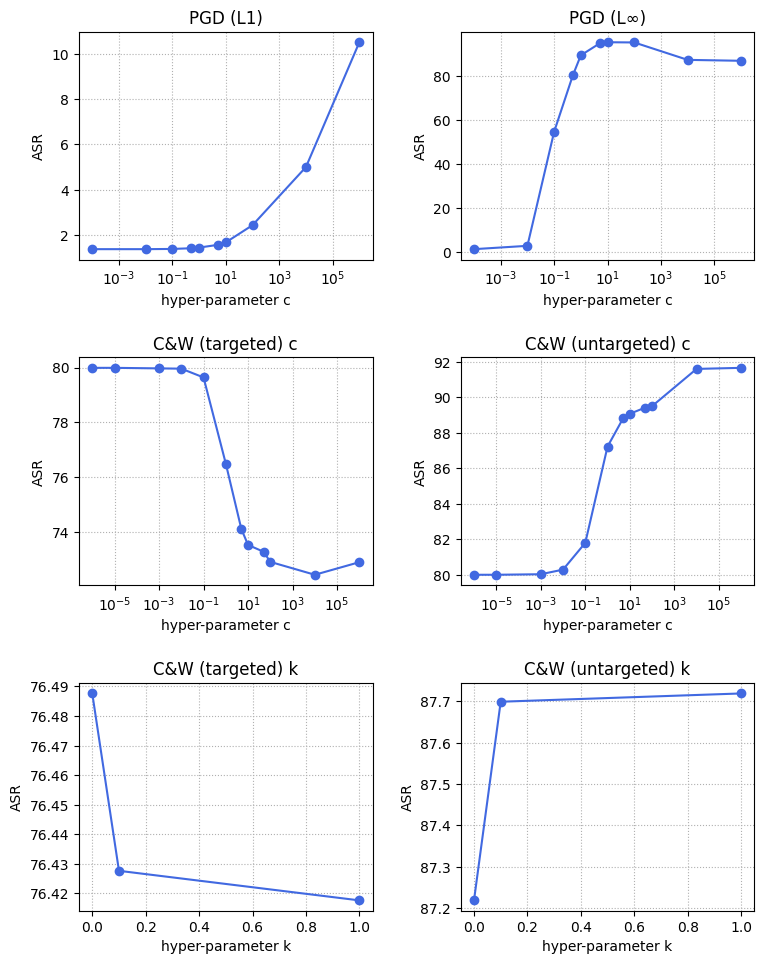

In [133]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()

for ax, (exp_name, data_points) in zip(axes, abltation_stats.items()):
    if exp_name == 'L1':
        exp_name = 'PGD (L1)'
    elif exp_name == 'Linf':
        exp_name = 'PGD (L∞)'
    elif exp_name == 'targeted c':
        exp_name = 'C&W (targeted) c'
    elif exp_name == 'untargeted c':
        exp_name = 'C&W (untargeted) c'
    elif exp_name == 'targeted k':
        exp_name = 'C&W (targeted) k'
    elif exp_name == 'untargeted k':
        exp_name = 'C&W (untargeted) k'
    
    # PGD
    if 'PGD' in exp_name:
        params, scores = zip(*data_points)
        ax.plot(params, scores, marker='o', color='royalblue')
        ax.set_xscale('log')
        ax.set_title(exp_name, fontsize=12)
        ax.set_xlabel('hyper-parameter c', fontsize=10)
        ax.set_ylabel('ASR', fontsize=10)
        ax.grid(True, linestyle=':')
    
    elif 'targeted) c' in exp_name:
        # c
        params, scores = zip(*data_points)
        ax.plot(params, scores, marker='o', color='royalblue')
        ax.set_xscale('log')
        ax.set_title(exp_name, fontsize=12)
        ax.set_xlabel('hyper-parameter c', fontsize=10)
        ax.set_ylabel('ASR', fontsize=10)
        ax.grid(True, linestyle=':')
    
    else:
        # k
        params, scores = zip(*data_points)
        ax.plot(params, scores, marker='o', color='royalblue')
        # ax.set_xscale('log')
        ax.set_title(exp_name, fontsize=12)
        ax.set_xlabel('hyper-parameter k', fontsize=10)
        ax.set_ylabel('ASR', fontsize=10)
        ax.grid(True, linestyle=':')

# 调整子图间距
plt.tight_layout(pad=2.0)
plt.show()

# Q3

In [113]:
class Defender():
    def __init__(self, attacker, model):
        ...

class AugmentDefender(Defender):
    def __init__(self, finetune, attacker, model, augment_ratio=0.1):
        self.finetune = finetune
        self.attacker = attacker
        self.augment_ratio = augment_ratio #训练集加入多少比例adv训练样本
        self.model = model

        self.loss_fn = nn.CrossEntropyLoss(reduction='mean')
        self.optimizer = optim.AdamW(self.model.parameters(), lr=0.0001)

    def defend(self, x, y):
        self.model.eval()
        adv_x = self.attacker.perturb(x, y)

        batch_size = x.size(0)
        num_adv = int(batch_size * self.augment_ratio)
        
        if num_adv > 0:
            mixed_x = torch.cat([x[:-num_adv], adv_x[-num_adv:]])
            mixed_y = y.clone()
        else:
            mixed_x, mixed_y = x, y
            
        return mixed_x, mixed_y


class AdversarialTrainingDefender(AugmentDefender):
    def __init__(
        self,
        attacker,
        model,
        augment_ratio: float = 0.1,
        lr: float = 1e-4
    ):
        """
        Adversarial training defender.
        
        Args:
            augment_ratio: Ratio of adversarial examples in each batch
        """
        self.attacker = attacker
        self.model = model
        self.augment_ratio = augment_ratio
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss(reduction='mean')
        
    def train_epoch(self, dataloader):
        """
        Train for one epoch with adversarial training.
        """
        self.model.train()
        total_loss = 0
        
        for batch in tqdm(dataloader, desc="Adversarial Training"):
            x = batch['feature']
            y = batch['label']    
            x, y = x.to(device), y.to(device)            
            defended_x, defended_y = self.defend(x, y)
            
            self.optimizer.zero_grad()
            outputs = self.model(defended_x)
            loss = self.criterion(outputs, defended_y)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            
        return total_loss / len(dataloader)
    
    def evaluate_robustness(self, dataloader):
        """
        Evaluate model robustness against attacks.
        
        Args:
            dataloader: Evaluation data loader
            attacker: Optional attacker to use (defaults to self.attacker)
            
        Returns:
            Tuple of (clean accuracy, robust accuracy)
        """
        self.model.eval()
        clean_correct = 0
        robust_correct = 0
        total = 0
        
        for batch in tqdm(dataloader, ncols=50, desc='Evaluating'):
            x = batch['feature']
            y = batch['label']    
            x, y = x.to(device), y.to(device)
            
            # Clean accuracy
            with torch.no_grad():
                outputs = self.model(x)
                _, predicted = torch.max(outputs.data, 1)
                clean_correct += (predicted == y).sum().item()
            
            # Robust accuracy (against attacks)
            adv_x = self.attacker.perturb(x, y)
            with torch.no_grad():
                outputs = self.model(adv_x)
                _, predicted = torch.max(outputs.data, 1)
                robust_correct += (predicted == y).sum().item()
            
            total += y.size(0)
            
        return clean_correct / total, robust_correct / total


In [115]:
def evaluate_defense(
    defender,
    test_loader,
    num_epochs: int = 10,
    eval_every: int = 1
) -> dict:
    """
    Evaluate defense performance over multiple epochs.
    
    Args:
        defender: Defender instance to evaluate
        test_loader: Test data loader
        num_epochs: Number of training epochs
        eval_every: Evaluate every N epochs
        
    Returns:
        Dictionary containing training metrics
    """
    results = {
        'train_loss': [],
        'clean_acc': [],
        'robust_acc': []
    }
    
    for epoch in range(1, num_epochs + 1):
        # Train for one epoch
        if isinstance(defender, (AugmentDefender, AdversarialTrainingDefender)):
            train_loss = defender.train_epoch(train_loader)
            results['train_loss'].append(train_loss)
        else:
            # For other defense types that don't need training
            pass
        
        # Evaluate periodically
        if epoch % eval_every == 0 or epoch == num_epochs:
            if isinstance(defender, AdversarialTrainingDefender):
                clean_acc, robust_acc = defender.evaluate_robustness(test_loader)
                results['clean_acc'].append(clean_acc)
                results['robust_acc'].append(robust_acc)
            else:
                clean_acc = defender.evaluate(test_loader)
                results['clean_acc'].append(clean_acc)
                
            print(f"Epoch {epoch}: Clean Acc = {clean_acc:.4f}", end="")
            if 'robust_acc' in results:
                print(f", Robust Acc = {robust_acc:.4f}")
            else:
                print()
                
    return results


Evaluating: 100%|█| 79/79 [00:05<00:00, 14.95it/s]


Epoch 1: Clean Acc = 0.9839, Robust Acc = 0.9838


Evaluating: 100%|█| 79/79 [00:05<00:00, 15.13it/s]


Epoch 2: Clean Acc = 0.9831, Robust Acc = 0.9828


Evaluating: 100%|█| 79/79 [00:05<00:00, 14.95it/s]


Epoch 3: Clean Acc = 0.9864, Robust Acc = 0.9863


Evaluating: 100%|█| 79/79 [00:04<00:00, 16.39it/s]


Epoch 4: Clean Acc = 0.9857, Robust Acc = 0.9852


Evaluating: 100%|█| 79/79 [00:05<00:00, 14.97it/s]


Epoch 5: Clean Acc = 0.9863, Robust Acc = 0.9859


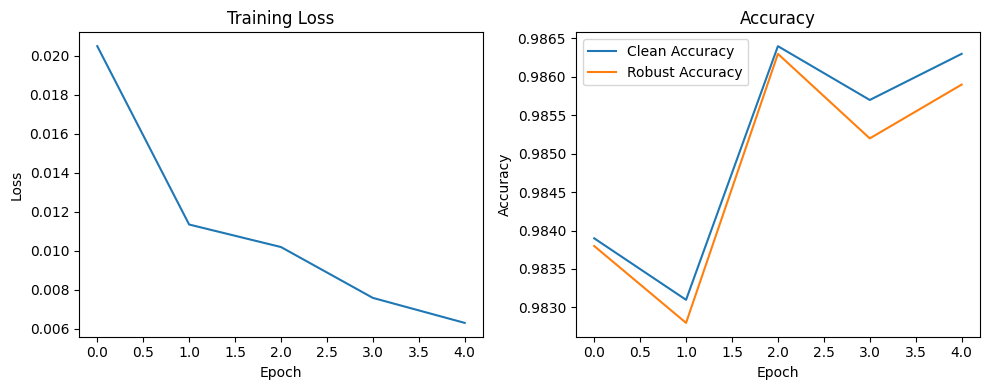

In [124]:
# 针对 PGD L1
defender = AdversarialTrainingDefender(attacker_l1, model, augment_ratio=0.3, lr=1e-3)
results = evaluate_defense(defender, test_loader, num_epochs=5)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(results['clean_acc'], label='Clean Accuracy')
if 'robust_acc' in results:
    plt.plot(results['robust_acc'], label='Robust Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()

Evaluating: 100%|█| 79/79 [00:03<00:00, 21.77it/s]


Epoch 1: Clean Acc = 0.9788, Robust Acc = 0.1941


Evaluating: 100%|█| 79/79 [00:03<00:00, 21.97it/s]


Epoch 2: Clean Acc = 0.9770, Robust Acc = 0.4700


Evaluating: 100%|█| 79/79 [00:03<00:00, 21.76it/s]


Epoch 3: Clean Acc = 0.9717, Robust Acc = 0.7295


Evaluating: 100%|█| 79/79 [00:03<00:00, 21.44it/s]


Epoch 4: Clean Acc = 0.9812, Robust Acc = 0.8313


Evaluating: 100%|█| 79/79 [00:03<00:00, 21.10it/s]


Epoch 5: Clean Acc = 0.9832, Robust Acc = 0.8853


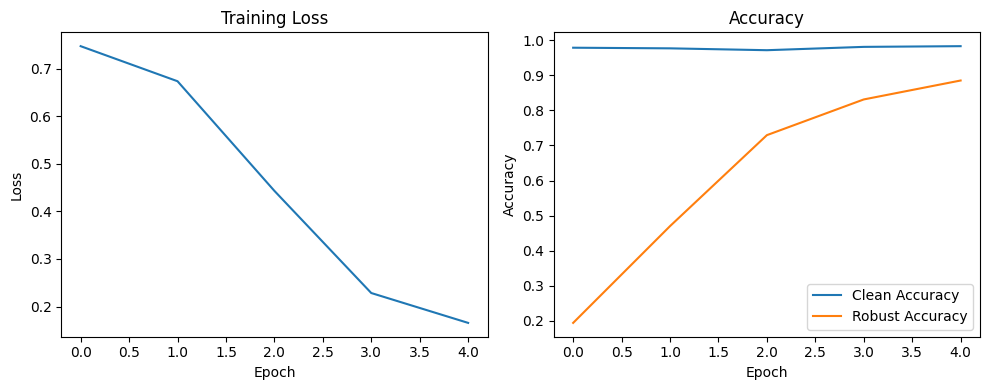

In [121]:
# 针对 PGD Linf
defender = AdversarialTrainingDefender(attacker_linf, model, augment_ratio=0.3, lr=5e-3)
results = evaluate_defense(defender, test_loader, num_epochs=5)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(results['clean_acc'], label='Clean Accuracy')
if 'robust_acc' in results:
    plt.plot(results['robust_acc'], label='Robust Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()

Evaluating: 100%|█| 79/79 [00:12<00:00,  6.51it/s]


Epoch 1: Clean Acc = 0.9774, Robust Acc = 0.8793


Evaluating: 100%|█| 79/79 [00:10<00:00,  7.27it/s]


Epoch 2: Clean Acc = 0.9744, Robust Acc = 0.8801


Evaluating: 100%|█| 79/79 [00:11<00:00,  7.03it/s]


Epoch 3: Clean Acc = 0.9739, Robust Acc = 0.9120


Evaluating: 100%|█| 79/79 [00:11<00:00,  6.99it/s]


Epoch 4: Clean Acc = 0.9787, Robust Acc = 0.9119


Evaluating: 100%|█| 79/79 [00:11<00:00,  7.06it/s]


Epoch 5: Clean Acc = 0.9778, Robust Acc = 0.9267


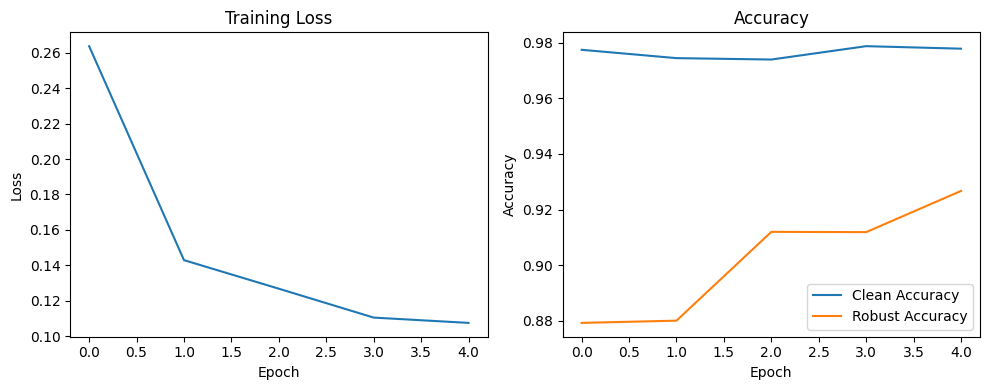

In [122]:
# 针对 C&W untargeted 攻击
defender = AdversarialTrainingDefender(attacker_untargeted, model, augment_ratio=0.3, lr=5e-3)
results = evaluate_defense(defender, test_loader, num_epochs=5)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(results['clean_acc'], label='Clean Accuracy')
if 'robust_acc' in results:
    plt.plot(results['robust_acc'], label='Robust Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()

Evaluating: 100%|█| 79/79 [01:43<00:00,  1.31s/it]


Epoch 1: Clean Acc = 0.9842, Robust Acc = 0.8666


Evaluating: 100%|█| 79/79 [01:04<00:00,  1.22it/s]


Epoch 2: Clean Acc = 0.9838, Robust Acc = 0.8759


Evaluating: 100%|█| 79/79 [00:11<00:00,  7.04it/s]


Epoch 3: Clean Acc = 0.9849, Robust Acc = 0.8898


Evaluating: 100%|█| 79/79 [00:12<00:00,  6.46it/s]


Epoch 4: Clean Acc = 0.9847, Robust Acc = 0.8977


Evaluating: 100%|█| 79/79 [00:10<00:00,  7.64it/s]


Epoch 5: Clean Acc = 0.9835, Robust Acc = 0.8971


Evaluating: 100%|█| 79/79 [00:11<00:00,  6.97it/s]


Epoch 6: Clean Acc = 0.9848, Robust Acc = 0.9026


Evaluating: 100%|█| 79/79 [00:12<00:00,  6.51it/s]


Epoch 7: Clean Acc = 0.9848, Robust Acc = 0.9066


Evaluating: 100%|█| 79/79 [00:09<00:00,  7.95it/s]


Epoch 8: Clean Acc = 0.9852, Robust Acc = 0.9084


Evaluating: 100%|█| 79/79 [00:11<00:00,  6.80it/s]


Epoch 9: Clean Acc = 0.9842, Robust Acc = 0.9129


Evaluating: 100%|█| 79/79 [00:11<00:00,  6.72it/s]


Epoch 10: Clean Acc = 0.9853, Robust Acc = 0.9163


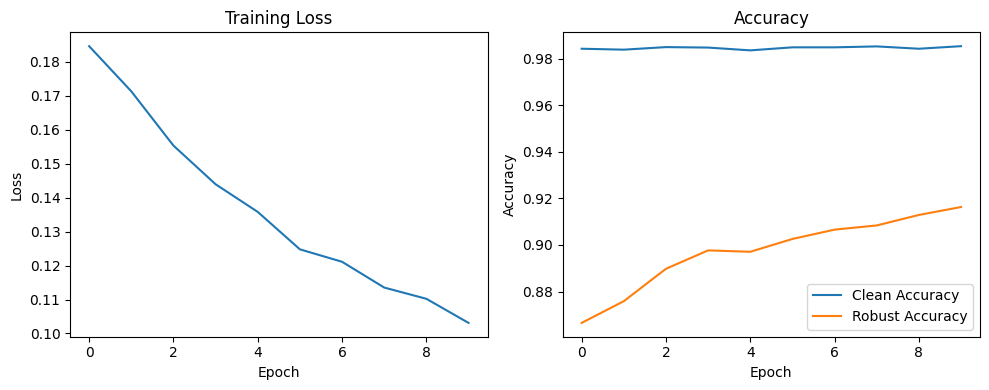

In [119]:
# 针对 C&W targeted 攻击
defender = AdversarialTrainingDefender(attacker_targeted, model, augment_ratio=0.3, lr=1e-4)
results = evaluate_defense(defender, test_loader, num_epochs=10)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(results['clean_acc'], label='Clean Accuracy')
if 'robust_acc' in results:
    plt.plot(results['robust_acc'], label='Robust Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()